# DFE and Acquisition in Dispersive Channels

We look at Decision Feedback Equalization and at how to acquire the preamble when the channel is dispersive.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/090_dispersive_acquisition_dfe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/090_dispersive_acquisition_dfe.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [2]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np
from scipy import signal
from scipy.linalg import toeplitz

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# the next cells, repeat code from earlier notebooks. It would be better to import these but
# then the notebook is no longer self-contained

In [3]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [6]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [7]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

## DFE

The DFE adds a second filter to the equalizer. The feedback filter cancels out the ISI from past symbols.

The outputs of the two filters are combined to produce the symbol-rate signal $y[m]$, which is input to the decision device. 

The signal $y[m]$ is given by
$$
      y[m] =  \vec{v}^H \cdot \vec{r}[mM] +  \vec{v}_b^H \cdot \vec{\hat{s}}[m].
$$
where $\vec{r}[mM]$ is a length $K_f$ vector of received samples starting at $mM$ and $\vec{\hat{s}}[m]$ is a vector of $K_b$ decisions prior to $m$.

We can combine the two summands
$$
      y[m] = \left[ \vec{v}, \vec{v}_b \right]^H \cdot
      \left[ \vec{r}[mM],  \vec{\hat{s}}[m] \right] =
      \langle \vec{r}_{\text{DFE}}[m], \vec{v}_{\text{DFE}} \rangle.
$$

Adaptation of the combined weight vector works exactly like for the linear equalizer. The objective function to minimize is
$$
      J_n(\vec{v}) = \sum_{m=0}^{n} \lambda^{n-m} |e[m]|^2 =
      \sum_{m=0}^n \lambda^{n-m} |s_m - \vec{v}_{\text{DFE}}^H \cdot \vec{r}_{\text{DFE}}[mM]|^2.
$$

### LMS Adaptation

The combined weight vector can be adapted as for the linear equalizer.

LMS Update:
$$
      \vec{v}_n = \vec{v}_{n-1} + \mu \vec{r}_{\text{DFE}}[nM] \cdot e^*[n].
$$
where the error signal $e[n]$ is 
$$
e[n] = s_n - \vec{v}_{\text{DFE}}^H \cdot \vec{r}_{\text{DFE}}[mM].
$$

In [35]:
class LMS():
    """class for carrying out the LMS algorithm"""

    def __init__(self, Kf, Kb, mu=0.5):
        self.Kf = Kf       # length of FF filter
        self.Kb = Kb       # <-- lengh of FB filter
        self.mu = mu       # forgetting factor

        self.v = np.zeros(Kf+Kb, dtype=complex)
        self.alpha = 0.1      # small positive constant

        self.sr = np.zeros(Kb, dtype=complex)  # <-- store recent decisions

    def update(self, vec_r, sym):
        """RLS recursion, returns updated weight vector"""
        # error
        e = sym - self.equalize(vec_r)

        # update weight vector
        scale = self.mu / (self.alpha + vec_r.conj() @ vec_r)
        # scale = self.mu
        self.v += np.concatenate( (vec_r, self.sr) ) * e.conj() * scale 

        if self.Kb > 0:
            self.sr[:] = np.concatenate((self.sr[1:], [sym])) # <-- store new symbol

        return self.v

    def equalize(self, vec_r):
        """compute equalizer output"""
        
        tmp = np.concatenate( (vec_r, self.sr) )  # <--- work BOTH filters
        return self.v.conj() @ tmp

In [86]:
## generate a QPSK signal
fsT = 2
N = 1000
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

syms = random_symbols(A, N)

## dispersive channel
ca = np.array([0.1,  -0.3j, 0, 1,  0, 0.3j, 0, 0, 0.2-0.7j, 0, 0, 0.1j])
sig = pulse_shape(syms, ca, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

# received signal
rra = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


In [87]:
## measure MSE for different training lengths Nt
Kf = 24    # length of FF filter
mu = 0.5
Kb = 2     # length of FB filter

Nt = np.arange(0, 200, 4)
MSE_L = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    lms = LMS(Kf, Kb, mu)
    
    Nm = 0
    m = 3
    while m*fsT + K < len(rra) and m < len(syms):
        vec_r = rra[m*fsT : m*fsT+K]

        if m <= this_Nt:
            # training
            lms.update(vec_r, syms[m])
        else:
            # equalize
            MSE_L[n] += np.abs(syms[m] - lms.equalize(vec_r))**2
            Nm += 1

        m += 1

    MSE_L[n] = MSE_L[n]/Nm

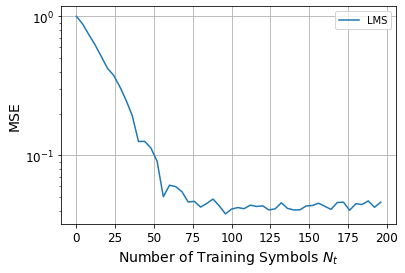

In [88]:
plt.semilogy(Nt, MSE_L, label="LMS")
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')
plt.legend()

plt.show()

### RLS Update

Similarly, the RLS updates are given by:

$$
      \vec{v}_{\text{DFE},n} = \vec{v}_{\text{DFE},n-1} +
      \frac{e^*[n] \mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM]}
      {\lambda + \vec{r}_{\text{DFE}}^H[nM]\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM]},
$$

and

$$
       \mathbf{R}_n^{-1} = \frac{1}{\lambda} \mathbf{R}_{n-1}^{-1} +
      \frac{(\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])
        (\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])^H}
      {1 + \vec{r}_{\text{DFE}}[nM]^H(\frac{1}{\lambda}\mathbf{R}_{n-1}^{-1} \vec{r}_{\text{DFE}}[nM])}.
$$


In [46]:
class RLS():
    """class for carrying out the RLS algorithm
    
    This class implements the RLS algorithm for a linear or DFE equalizer.

    It has the following parameters:
    - Kf: length of feedforward filter
    - Kb: length of feedback filter, set to 0 for linear equalizer
    - fsT: oversampling factor for FF filter
    - lam: forgetting factor (0 < lamda <= 1)

    The RLS class provides two methods:
    - update: computes updated weights based on the difference between the eualizer output and the symbol decision
    - equalize: computes the equalizer output
    both methods are invoked once per symbol period.

    The order of invocation must be: equalize -> decision -> update
    """

    def __init__(self, Kf: int, Kb: int, fsT: int, lam:float = 1.) -> None:
        self.Kf = Kf       # length of FF filter
        self.Kb = Kb       # length of FB filter
        self.M = fsT       # oversampling factor for FF filter
        self.lam = lam     # forgetting factor

        self.R_inv = 1*np.eye(Kf+Kb, dtype=complex)  # inverse of auto-correlation matrix
        self.v = np.zeros(Kf+Kb, dtype=complex)      # weight vector

        ## shift register holds both recent samples and recent training symbols (or decsions)
        # the received samples are stored in the first Kf positions, the symbols are stored in the 
        # final Kb positions
        self.sr = np.zeros(Kb, dtype=complex)


    def update(self, vec_rr, sym):
        """RLS recursion, returns updated weight vector

        Inputs:
        - vec_rr - vector of samples
        - sym - the most recent training symbol or decision

        Returns:
        - updated weight vector

        Updates:
        all state variables are updated with the RLS algorithm 
        
        """
        # error
        e = sym - self.equalize(vec_rr)

        # compute R_inv * vec_r
        tmp = np.concatenate((vec_rr, self.sr))
        vec_g = self.R_inv @ np.expand_dims(tmp, 1)

        # update R_inv
        denom = (self.lam + tmp.conj() @ vec_g)
        self.R_inv = 1/self.lam * (self.R_inv - 
                    vec_g @ vec_g.conj().T / denom)

        # update weight vector
        self.v += np.squeeze(vec_g) * e.conj()/denom

        # update the shift register that holds decisions
        if self.Kf > 0:
            self.sr[:] = np.concatenate((self.sr[1:], [sym]))

        return self.v

    def equalize(self, vec_rr):
        """compute equalizer output
        
        Inputs:
        vec_rr - vector of samples

        Returns:
        - equalizer output

        Updates:
        the state of the equalizer is unchanged
        """
        tmp = np.concatenate((vec_rr, self.sr))
        
        return self.v.conj() @ tmp

In [91]:
## Test RLS equalizer
Kf = 8*fsT
Kb = 0
lam = 0.99

Nt = np.arange(0, 200, 4)
MSE = np.zeros_like(Nt, dtype=float)

for n in range(len(Nt)):
    this_Nt = Nt[n]

    # instantiate RLS
    rls = RLS(Kf, Kb, fsT, lam)
    
    Nm = 0
    m = 0
    while  m*fsT+Kf < len(rra) and m < len(syms):
        # vec_r = rra[m*fsT : m*fsT+K]
        vec_r = rra[m*fsT : m*fsT+Kf]

        if m <= this_Nt:
            # training
            v = rls.update(vec_r, syms[m])
        else:
            # equalize
            MSE[n] += np.abs(syms[m] - rls.equalize(vec_r))**2
            Nm += 1

        m += 1

    MSE[n] = MSE[n]/Nm

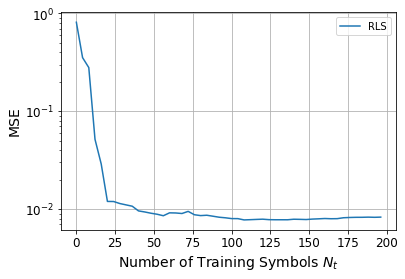

In [92]:
plt.semilogy(Nt, MSE, label="RLS")
plt.grid()

plt.xlabel('Number of Training Symbols $N_t$')
plt.ylabel('MSE')
plt.legend()

plt.show()

##  Detection in Dispersive Channels

When the channel is dispersive, the detection of the preamble is not obvious. The correlation between the received signal and the preamble sequence will have multiple peaks. The peaks are reflective of the impulse repsonse of the channel.

Recall that we modeled the received signal as 
$$
    \vec{r}[k] = \mathbf{S} \vec{c} + \vec{N}.
$$

We will use this model to detect the preamble. For that purpose:
* $\vec{r}[k]$ is the vector of received samples starting at sample index $k$; the length of this vector is equal to the length $NM$ of the preamble in sample periods.
* $\mathbf{S}$ is the Toeplitz matrix construted from the symbols of the preamble sequence. It has $NM$ rows and $LM$ columns, where $L$ is the delay spread of the channel in symbol periods.
* $\vec{c}$ is the unknown channel impulse response.

The detection problem (if $\vec{c}$ were known) is
$$
    \hat{k} = \arg \min \|\vec{r}[k] - \mathbf{SS} \vec{c}\|^2.
$$

Since $\vec{c}$ is not known, we replace it with its maximum likelihood estimate:
$$
    \hat{c} = (\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k].
$$

Then, the detection criterion becomes
$$
\hat{k} = \arg \min \|\vec{r}[k] - \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k]\|^2.
$$

I.e., the criterion compares $\vec{r}[k]$ and the projection of $\vec{r}[k]$ into the suspace spanned by the preamble sequence.

In practice, a detection occurs at time $k$ when
$$
    \rho[k] = \frac{\| \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k] \|^2}
    {\|\vec{r}[k]\|^2} > \gamma
$$
where $0< \gamma \leq 1$ is a suitably chose threshold.

**Note:** The matrix $\mathbf{S}$ contains many zeros. This can be exploited to reduce the computational complexity of teh expression above. Similarly, the matrix product $\mathbf{S}^H\mathbf{S}$ will be strongly diagonal for a good preamble sequence which can be further exploited. 

In [93]:
## preamble signal
Np = 31      # length of preamble
fb = 5      # LFSR feedback

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
pn = Ap[lfsr(1, fb, Np, 5)]

In [56]:
## construct preamble followed by signal
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK alphabet

N = 100
syms = random_symbols(A, N)

## dispersive channel
fsT = 2
ca = np.array([0.1,  -0.3j, 0, 1,  0, 0.3j, 0, 0, 0.2-0.7j, 0, 0, 0.1j])
sig = pulse_shape(np.concatenate((pn,syms)), ca, fsT)

SNR_db = 20
SNR = 10**(SNR_db/10)

delay = 31
sig = np.concatenate((np.zeros(delay, dtype=complex), sig))

# frequency offset
f_off = 0.002
sig = sig * np.exp(2j*np.pi*f_off*np.arange(len(sig)))

# received signal
rr = sig + 1/(np.sqrt(2*SNR))*(np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))


The matrix $\mathbf{S}$ can be pre-computed from the preamble symbols.

In [57]:
## construct the matrix SS
sc = np.zeros(Np*fsT, dtype=complex)
sc[::fsT] = pn

sr = np.zeros_like(ca)
sr[0] = pn[0]

SS = toeplitz(sc, sr)

## compute the projection matrix for SS
SSp = SS @ np.linalg.pinv(SS)

Now we can compute $\rho[k]$ for sample indices $k$. Usually this would be done in a loop that terminates once the threshold $\gamma$ is breached.

In [74]:
rho = np.zeros(100)

for m in range(100):
    this_rr = np.expand_dims(rr[m:m+62], 1)
    rp = SSp @ this_rr

    tmp = np.squeeze( (rp.conj().T @ rp) /  (this_rr.conj().T @ this_rr) )
    rho[m] = np.real(tmp)

print("The maximum of rho occurs at k = {:d} (true delay: {:d})".format(np.argmax(rho), delay))

The maximum of rho occurs at k = 31 (true delay: 31)


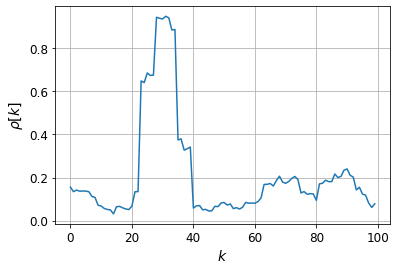

In [75]:
plt.plot(rho)
plt.grid()
plt.xlabel('$k$')
plt.ylabel(r'$\rho[k]$')
plt.show()

### Estimating the Frequency Offset

We have been able to locate the start of the preamble at sample $k=31$. 

Since the preamble sequence contains 31 symbols sampled at 2 samples per symbol, the preamble contains 62 samples.

The projection of $\vec{r}$ into the subspace spanned by $\mathbf{S}$ is  
$$
\vec{\hat{r}}[k] = \mathbf{S}(\mathbf{S}^H\mathbf{S})^{-1}\mathbf{S}^H\vec{r}[k] = \mathbf{S} \vec{\hat{c}}.
$$

Since $\vec{\hat{c}}$ is constant, it cannnot reflect the frequency offset in the received signal.

This suggest that we can estimate the frequency offset from the phase difference between $\vec{\hat{r}}$ and $\vec{r}$.

In [79]:
## project the received preamble samples onto the space spanned by S
d = np.argmax(rho) 
L = len(pn)*fsT

# projection
rrp = np.squeeze( SSp @ np.expand_dims(rr[d:d+L], 1) )

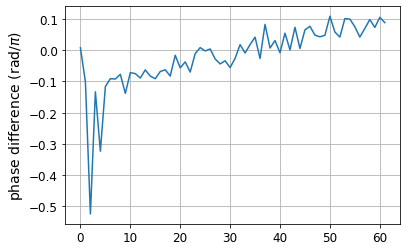

In [81]:
## compute and plot the phase difference between projection and signal
plt.plot(np.angle(rrp.conj() * rr[d:d+L])/np.pi)
plt.grid()

plt.ylabel('phase difference (rad/$\pi$)')
plt.show()

In [85]:
## estimate the frequency error
# since phase error is erratice at the start, we skip the first few samples
skip = 12

pd = np.angle(rrp.conj() * rr[d:d+L])
f_est = (pd[-1] - pd[skip]) / (L-skip) / (2*np.pi)

print("Estimated frequency offset: {:6.4f} (true: {:6.4f})".format(f_est, f_off))


Estimated frequency offset: 0.0018 (true: 0.0020)
